**Lab 3 – Relational Database and data wrangling**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math608/blob/master/static_files/presentations/03_Relational_Database_and_data_wrangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/nsysu-math608/blob/master/static_files/presentations/03_Relational_Database_and_data_wrangling.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

In [ ]:
from google.cloud import bigquery
import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

## Queringing data with bigquery

Structured Query Language, or SQL, is the programming language used with databases, and it is an important skill for any data scientist. In this example, you'll build your SQL skills using BigQuery, a web service work as database management system that lets you apply SQL to huge datasets.

### Preliminaries for google colab (optional)

We want to start exploring the Google BiqQuery [public datasets](https://cloud.google.com/bigquery/public-data/). Let's start by walking through the required setup steps, and then we can load and explore some data.

If you are using colab. Follow [this quickstart guide](https://cloud.google.com/bigquery/docs/quickstarts/quickstart-client-libraries), which will explain how to:
1. Create a [Cloud Platform project](https://console.cloud.google.com/cloud-resource-manager) if you don't have one already.
2. [Enable billing](https://support.google.com/cloud/answer/6293499#enable-billing) for the project
3. [Enable the BigQuery API](https://console.cloud.google.com/flows/enableapi?apiid=bigquery)
4. [Enabling the Service account](https://cloud.google.com/docs/authentication/getting-started)

Now we need to authenticate to gain access to the BigQuery API. We will create a client, specifying the service account key file (replace 'lunar-pact-378812-7a28b789bde2.json' with your key file).

In [ ]:
# @title Setup
from google.oauth2 import service_account

# TODO(developer): Set key_path to the path to the service account key file.

key_path = "lunar-pact-378812-7a28b789bde2.json"

credentials = service_account.Credentials.from_service_account_file(
    key_path
)

In [ ]:
# @title Alternative Setup
#from google.colab import auth
#from google.cloud import bigquery
#from google.colab import data_table

#project = 'lunar-pact-378812' # Project ID inserted based on the query results selected to explore
#location = 'US' # Location inserted based on the query results selected to explore
#client = bigquery.Client(project=project, location=location)
#data_table.enable_dataframe_formatter()
#auth.authenticate_user()

Now that we're authenticated, we need to load the BigQuery package, and the `google.colab.data_table` package that can be used to display large pandas dataframes as an interactive data. Loading `data_table` is optional, but it will be useful for working with data in pandas.

In [ ]:
%load_ext google.cloud.bigquery
%load_ext google.colab.data_table

In [ ]:
client = bigquery.Client(credentials=credentials, project=credentials.project_id,)

### Create the reference


You can also work with Kaggle, which provide bigquery integration that you do not need to setup a google account. **Each Kaggle user can scan 5TB every 30 days for free.  Once you hit that limit, you'll have to wait for it to reset.** See https://www.kaggle.com/product-feedback/48573 for more details.


The first step in the workflow is to create a [`Client`](https://cloud.google.com/python/docs/reference/bigquery/latest/google.cloud.bigquery.client.Client) object.  As you'll soon see, this `Client` object will play a central role in retrieving information from BigQuery datasets.

In [ ]:
# Uncomment below and create a "Client" object if you are using Kaggle
# client = bigquery.Client()

We'll work with a dataset of posts on Hacker News, a website focusing on computer science and cybersecurity news. In BigQuery, each dataset is contained in a corresponding project. In this case, our `hacker_news` dataset is contained in the `bigquery-public-data project`. 

To access the dataset, We begin by constructing a reference to the dataset with the [`dataset()`](https://cloud.google.com/python/docs/reference/bigquery/latest/google.cloud.bigquery.dataset.Dataset) method. Next, we use the [`get_dataset()`](https://cloud.google.com/python/docs/reference/bigquery/latest/google.cloud.bigquery.client.Client#google_cloud_bigquery_client_Client_get_dataset) method, along with the reference we just constructed, to fetch the dataset.

[See the full list of public datasets](https://console.cloud.google.com/marketplace/browse?filter=solution-type:dataset) or the [kaggle bigquery dataset](https://www.kaggle.com/datasets?search=bigquery) if you want to explore others.

In [ ]:
# Construct a reference to the "hacker_news" dataset
dataset_ref = client.dataset("hacker_news", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

Every dataset is just a collection of tables. You can think of a dataset as a spreadsheet file containing multiple tables, all composed of rows and columns.We use the [`list_tables()`](https://cloud.google.com/python/docs/reference/bigquery/latest/google.cloud.bigquery.client.Client#google_cloud_bigquery_client_Client_list_tables) method to list the tables in the dataset.

In [ ]:
# List all the tables in the "hacker_news" dataset
tables = list(client.list_tables(dataset))

# Print names of all tables in the dataset (there are four!)
for table in tables:  
    print(table.table_id)

comments
full
full_201510
stories


Similar to how we fetched a dataset, we can fetch a table. In the code cell below, we fetch the `full` table in the hacker_news dataset

In [ ]:
# Construct a reference to the "full" table
table_ref = dataset_ref.table("full")

# API request - fetch the table
table = client.get_table(table_ref)

In the next section, you'll explore the contents of this table in more detail.  For now, take the time to use the image below to consolidate what you've learned so far.

![first_commands](https://i.imgur.com/biYqbUB.png)

### Table schema

The structure of a table is called its **schema**.  **We need to understand a table's schema to effectively pull out the data we want.** 

In this example, we'll investigate the `full` table that we fetched above.

In [ ]:
# Print information on all the columns in the "full" table in the "hacker_news" dataset
table.schema

[SchemaField('title', 'STRING', 'NULLABLE', None, 'Story title', (), None),
 SchemaField('url', 'STRING', 'NULLABLE', None, 'Story url', (), None),
 SchemaField('text', 'STRING', 'NULLABLE', None, 'Story or comment text', (), None),
 SchemaField('dead', 'BOOLEAN', 'NULLABLE', None, 'Is dead?', (), None),
 SchemaField('by', 'STRING', 'NULLABLE', None, "The username of the item's author.", (), None),
 SchemaField('score', 'INTEGER', 'NULLABLE', None, 'Story score', (), None),
 SchemaField('time', 'INTEGER', 'NULLABLE', None, 'Unix time', (), None),
 SchemaField('timestamp', 'TIMESTAMP', 'NULLABLE', None, 'Timestamp for the unix time', (), None),
 SchemaField('type', 'STRING', 'NULLABLE', None, 'Type of details (comment, comment_ranking, poll, story, job, pollopt)', (), None),
 SchemaField('id', 'INTEGER', 'NULLABLE', None, "The item's unique id.", (), None),
 SchemaField('parent', 'INTEGER', 'NULLABLE', None, 'Parent comment ID', (), None),
 SchemaField('descendants', 'INTEGER', 'NULLABL

Each [`SchemaField`](https://cloud.google.com/python/docs/reference/bigquery/latest/google.cloud.bigquery.schema.SchemaField) tells us about a specific column (which we also refer to as a **field**). In order, the information is:

* The **name** of the column
* The **field type** (or datatype) in the column
* The **mode** of the column (`'NULLABLE'` means that a column allows NULL values, and is the default)
* A **description** of the data in that column

For instance, the field has the SchemaField:

`SchemaField('by', 'string', 'NULLABLE', "The username of the item's author.",())`

This tells us:
- the field (or column) is called `by`,
- the data in this field is strings, 
- NULL values are allowed, and
- it contains the usernames corresponding to each item's author.

We can use the [`list_rows()`](https://cloud.google.com/python/docs/reference/bigquery/latest/google.cloud.bigquery.client.Client#google_cloud_bigquery_client_Client_list_rows) method to check just the first five lines of of the `full` table to make sure this is right.  This returns a BigQuery [`RowIterator`](https://cloud.google.com/python/docs/reference/bigquery/latest/google.cloud.bigquery.table.RowIterator) object that can quickly be converted to a pandas DataFrame with the [`to_dataframe()`](https://cloud.google.com/python/docs/reference/bigquery/latest/google.cloud.bigquery.table.RowIterator#google_cloud_bigquery_table_RowIterator_to_dataframe) method.

In [ ]:
# Preview the first five lines of the "full" table
client.list_rows(table, max_results=5).to_dataframe()

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
0,None,None,"I would rather just have wired earbuds, period...",<NA>,zeveb,<NA>,1591717736,2020-06-09 15:48:56+00:00,comment,23467666,23456782,<NA>,<NA>,<NA>
1,None,None,DNS?,<NA>,nly,<NA>,1572810465,2019-11-03 19:47:45+00:00,comment,21436112,21435130,<NA>,<NA>,<NA>
2,None,None,These benchmarks seem pretty good. Filterable...,<NA>,mrkeen,<NA>,1591717727,2020-06-09 15:48:47+00:00,comment,23467665,23467426,<NA>,<NA>,<NA>
3,None,None,Oh really?<p>* Excel alone uses 86.1MB of priv...,<NA>,oceanswave,<NA>,1462987532,2016-05-11 17:25:32+00:00,comment,11677248,11676886,<NA>,<NA>,<NA>
4,None,None,These systems are useless. Of the many flaws:...,<NA>,nyxxie,<NA>,1572810473,2019-11-03 19:47:53+00:00,comment,21436113,21435025,<NA>,<NA>,<NA>


The `list_rows()` method will also let us look at just the information in a specific column. If we want to see the first five entries in the `by` column, for example, we can do that!

In [ ]:
# Preview the first five entries in the "by" column of the "full" table
client.list_rows(table, selected_fields=table.schema[4:5], max_results=5).to_dataframe()

,by
0,zeveb
1,nly
2,mrkeen
3,oceanswave
4,nyxxie


### Select, From & Where

Now that you know how to access and examine a dataset, you're ready to write your first SQL query!  As you'll soon see, **SQL queries will help you sort through a massive dataset, to retrieve only the information that you need.** We'll begin by using the keywords **SELECT**, **FROM**, and **WHERE** to get data from specific columns based on conditions you specify. 

We'll use an [OpenAQ](https://openaq.org) dataset about air quality. First, we'll set up everything we need to run queries and take a quick peek at what tables are in our database.

In [ ]:
# Construct a reference to the "openaq" dataset
dataset_ref = client.dataset("openaq", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# List all the tables in the "openaq" dataset
tables = list(client.list_tables(dataset))

# Print names of all tables in the dataset (there's only one!)
for table in tables:  
    print(table.table_id)

global_air_quality


The dataset contains only one table, called `global_air_quality`.  We'll fetch the table and take a peek at the first few rows to see what sort of data it contains.

In [ ]:
# Construct a reference to the "global_air_quality" table
table_ref = dataset_ref.table("global_air_quality")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the "global_air_quality" table
client.list_rows(table, max_results=5).to_dataframe()

,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude,averaged_over_in_hours,location_geom
0,"Borówiec, ul. Drapałka",Borówiec,PL,bc,0.85217,2022-04-28 07:00:00+00:00,µg/m³,GIOS,1.0,52.276794,17.074114,POINT(52.276794 1)
1,"Kraków, ul. Bulwarowa",Kraków,PL,bc,0.91284,2022-04-27 23:00:00+00:00,µg/m³,GIOS,1.0,50.069308,20.053492,POINT(50.069308 1)
2,"Płock, ul. Reja",Płock,PL,bc,1.41000,2022-03-30 04:00:00+00:00,µg/m³,GIOS,1.0,52.550938,19.709791,POINT(52.550938 1)
3,"Elbląg, ul. Bażyńskiego",Elbląg,PL,bc,0.33607,2022-05-03 13:00:00+00:00,µg/m³,GIOS,1.0,54.167847,19.410942,POINT(54.167847 1)
4,"Piastów, ul. Pułaskiego",Piastów,PL,bc,0.51000,2022-05-11 05:00:00+00:00,µg/m³,GIOS,1.0,52.191728,20.837489,POINT(52.191728 1)


let's put together a query. Say we want to select all the values from the `city` column that are in rows where the `country` column is `'US'` (for "United States").

In [13]:
# Query to select all the items from the "city" column where the "country" column is 'US'
# SQL is almost completely case and indentation insensitive. The capitalization and
# indentation style here is preferred style.
query = """
        SELECT city
        FROM `bigquery-public-data.openaq.global_air_quality`
        WHERE country = 'US'
        """

Notice also that SQL statements requires single quotes for its strings inside python string (we use triple quotation mark here). We begin by setting up the query with the [`query()`](https://cloud.google.com/python/docs/reference/bigquery/latest/google.cloud.bigquery.client.Client#google_cloud_bigquery_client_Client_query) method.

In [14]:
# Set up the query
query_job = client.query(query)

# API request - run the query, and return a pandas DataFrame
us_cities = query_job.to_dataframe()

Now we've got a pandas DataFrame called `us_cities`, which we can use like any other DataFrame.

In [15]:
# What five cities have the most measurements?
us_cities.city.value_counts().head()

Phoenix-Mesa-Scottsdale                     39414
Los Angeles-Long Beach-Santa Ana            27479
Riverside-San Bernardino-Ontario            26887
New York-Northern New Jersey-Long Island    25417
San Francisco-Oakland-Fremont               22710
Name: city, dtype: int64

If you want multiple columns, you can select them with a comma between the names:

In [ ]:
query = """
        SELECT city, country
        FROM `bigquery-public-data.openaq.global_air_quality`
        WHERE country = 'US'
        """

You can select all columns with a `*` like this:

In [ ]:
query = """
        SELECT *
        FROM `bigquery-public-data.openaq.global_air_quality`
        WHERE country = 'US'
        """

### Querying big dataset

You can estimate the size of any query before running it. Here is an example using the Hacker News dataset. To see how much data a query will scan, we create a [`QueryJobConfig`](https://cloud.google.com/python/docs/reference/bigquery/latest/google.cloud.bigquery.job.QueryJobConfig) object and set the `dry_run` parameter to `True`.

In [16]:
# Query to get the score column from every row where the type column has value "job"
query = """
        SELECT score, title
        FROM `bigquery-public-data.hacker_news.full`
        WHERE type = "job" 
        """

# Create a QueryJobConfig object to estimate size of query without running it
dry_run_config = bigquery.QueryJobConfig(dry_run=True)

# API request - dry run query to estimate costs
dry_run_query_job = client.query(query, job_config=dry_run_config)

print("This query will process {} bytes.".format(dry_run_query_job.total_bytes_processed))

This query will process 553320240 bytes.


You can also specify a parameter when running the query to limit how much data you are willing to scan. Here's an example with a low limit.

In [18]:
# Only run the query if it's less than 1 MB
ONE_MB = 1000*1000
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=ONE_MB)

# Set up the query (will only run if it's less than 1 MB)
safe_query_job = client.query(query, job_config=safe_config)

# API request - try to run the query, and return a pandas DataFrame
safe_query_job.to_dataframe()

InternalServerError: ignored

In this case, the query was cancelled, because the limit of 1 MB was exceeded.  However, we can also increase the limit to run the query successfully!

### Group By, Having & Count

Now that you can select raw data, you're ready to learn how to group your data and count things within those groups.

The Hacker News dataset contains information on stories and comments from the Hacker News social networking site. We'll work with the `comments` table and begin by printing the first few rows

In [19]:
# Construct a reference to the "hacker_news" dataset
dataset_ref = client.dataset("hacker_news", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "comments" table
table_ref = dataset_ref.table("comments")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the "comments" table
client.list_rows(table, max_results=5).to_dataframe()

,id,by,author,time,time_ts,text,parent,deleted,dead,ranking
0,9734136,None,None,1434565400,2015-06-17 18:23:20+00:00,None,9733698,True,<NA>,0
1,4921158,None,None,1355496966,2012-12-14 14:56:06+00:00,None,4921100,True,<NA>,0
2,7500568,None,None,1396261158,2014-03-31 10:19:18+00:00,None,7499385,True,<NA>,0
3,8909635,None,None,1421627275,2015-01-19 00:27:55+00:00,None,8901135,True,<NA>,0
4,9256463,None,None,1427204705,2015-03-24 13:45:05+00:00,None,9256346,True,<NA>,0


Let's use the table to see which comments generated the most replies.  Since:
- the `parent` column indicates the comment that was replied to, and 
- the `id` column has the unique ID used to identify each comment, 

we can **GROUP BY** the `parent` column and **COUNT()** the `id` column in order to figure out the number of comments that were made as responses to a specific comment.

Furthermore, since we're only interested in popular comments, we'll look at comments with more than ten replies.  So, we'll only return groups **HAVING** more than ten ID's.

In [20]:
# Query to select comments that received more than 10 replies
query_popular = """
                SELECT parent, COUNT(id)
                FROM `bigquery-public-data.hacker_news.comments`
                GROUP BY parent
                HAVING COUNT(id) > 10
                """

In [21]:
# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query_popular, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
popular_comments = query_job.to_dataframe()

# Print the first five rows of the DataFrame
popular_comments.head()

,parent,f0_
0,9399394,39
1,9238839,314
2,6913456,47
3,4233505,50
4,3952263,48


In [22]:
popular_comments

,parent,f0_
0,9399394,39
1,9238839,314
2,6913456,47
3,4233505,50
4,3952263,48
...,...,...
77363,6287340,37
77364,1772903,37
77365,4065233,37
77366,8098496,37


Each row in the `popular_comments` DataFrame corresponds to a comment that received more than ten replies.

A couple hints to make your queries even better:
- The column resulting from `COUNT(id)` was called `f0__`. That's not a very descriptive name. You can change the name by adding `AS NumPosts` after you specify the aggregation. This is called **aliasing**.
- If you are ever unsure what to put inside the **COUNT()** function, you can do `COUNT(1)` to count the rows in each group. Most people find it especially readable, because we know it's not focusing on other columns. It also scans less data than if supplied column names (making it faster and using less of your data access quota).

Using these tricks, we can rewrite our query:

In [23]:
# Improved version of earlier query, now with aliasing & improved readability
query_improved = """
                 SELECT parent, COUNT(1) AS NumPosts
                 FROM `bigquery-public-data.hacker_news.comments`
                 GROUP BY parent
                 HAVING COUNT(1) > 10
                 """

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query_improved, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
improved_df = query_job.to_dataframe()

# Print the first five rows of the DataFrame
improved_df.head()

,parent,NumPosts
0,7117131,40
1,6068323,49
2,4015954,46
3,3231531,53
4,7152068,101


In [24]:
improved_df

,parent,NumPosts
0,7117131,40
1,6068323,49
2,4015954,46
3,3231531,53
4,7152068,101
...,...,...
77363,9368401,37
77364,6653024,37
77365,1440303,37
77366,9215890,37


Now you have the data you want, and it has descriptive names. 

#### Note on using **GROUP BY**

Note that because it tells SQL how to apply aggregate functions (like **COUNT()**), it doesn't make sense to use **GROUP BY** without an aggregate function.  Similarly, if you have any **GROUP BY** clause, then all variables must be passed to either a
1. **GROUP BY** command, or
2. an aggregation function.

Consider the query below:



In [ ]:
query_good = """
             SELECT parent, COUNT(id)
             FROM `bigquery-public-data.hacker_news.comments`
             GROUP BY parent
             """

Note that there are two variables: `parent` and `id`. 
- `parent` was passed to a **GROUP BY** command (in `GROUP BY parent`), and 
- `id` was passed to an aggregate function (in `COUNT(id)`).

And the query below won't work, because the `author` column isn't passed to an aggregate function or a **GROUP BY** clause:

In [25]:
query_bad = """
            SELECT author, parent, COUNT(id)
            FROM `bigquery-public-data.hacker_news.comments`
            GROUP BY parent
            """

In [28]:
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query_bad, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
improved_df = query_job.to_dataframe()

# Print the first five rows of the DataFrame
improved_df.head()

BadRequest: ignored

### Order By

Frequently, you’ll want to sort your results. **Let's use the US Traffic Fatality Records database, which contains information on traffic accidents in the US where at least one person died.**

We'll investigate the `accident_2015` table. Here is a view of the first few rows. 

In [29]:
# Construct a reference to the "nhtsa_traffic_fatalities" dataset
dataset_ref = client.dataset("nhtsa_traffic_fatalities", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "accident_2015" table
table_ref = dataset_ref.table("accident_2015")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the "accident_2015" table
client.list_rows(table, max_results=5).to_dataframe()

,state_number,state_name,consecutive_number,number_of_vehicle_forms_submitted_all,number_of_motor_vehicles_in_transport_mvit,number_of_parked_working_vehicles,number_of_forms_submitted_for_persons_not_in_motor_vehicles,number_of_persons_not_in_motor_vehicles_in_transport_mvit,number_of_persons_in_motor_vehicles_in_transport_mvit,number_of_forms_submitted_for_persons_in_motor_vehicles,...,minute_of_ems_arrival_at_hospital,related_factors_crash_level_1,related_factors_crash_level_1_name,related_factors_crash_level_2,related_factors_crash_level_2_name,related_factors_crash_level_3,related_factors_crash_level_3_name,number_of_fatalities,number_of_drunk_drivers,timestamp_of_crash
0,30,Montana,300019,5,5,0,0,0,7,7,...,45,0,None,0,None,0,None,1,0,2015-03-28 14:58:00+00:00
1,39,Ohio,390099,7,7,0,0,0,15,15,...,24,27,Backup Due to Prior Crash,0,None,0,None,1,0,2015-02-14 11:19:00+00:00
2,49,Utah,490123,16,16,0,0,0,28,28,...,99,0,None,0,None,0,None,1,0,2015-04-14 12:24:00+00:00
3,48,Texas,481184,6,5,1,0,5,5,10,...,99,0,None,0,None,0,None,1,0,2015-05-27 16:40:00+00:00
4,41,Oregon,410333,11,11,0,0,0,14,14,...,99,0,None,0,None,0,None,1,0,2015-11-17 18:17:00+00:00


Let's use the table to determine how the number of accidents varies with the day of the week.  Since:
- the `consecutive_number` column contains a unique ID for each accident, and
- the `timestamp_of_crash` column contains the date of the accident in [DATETIME](https://cloud.google.com/bigquery/docs/reference/standard-sql/date_functions) format,

we can:
- **EXTRACT** the day of the week (as `day_of_week` in the query below) from the `timestamp_of_crash` column, and
- **GROUP BY** the day of the week, before we **COUNT** the `consecutive_number` column to determine the number of accidents for each day of the week.

Then we sort the table with an **ORDER BY** clause, so the days with the most accidents are returned first.

In [30]:
# Query to find out the number of accidents for each day of the week
query = """
        SELECT COUNT(consecutive_number) AS num_accidents, 
               EXTRACT(DAYOFWEEK FROM timestamp_of_crash) AS day_of_week
        FROM `bigquery-public-data.nhtsa_traffic_fatalities.accident_2015`
        GROUP BY day_of_week
        ORDER BY num_accidents DESC
        """

In [31]:
# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 1 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**9)
query_job = client.query(query, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
accidents_by_day = query_job.to_dataframe()

# Print the DataFrame
accidents_by_day

,num_accidents,day_of_week
0,5659,7
1,5298,1
2,4916,6
3,4460,5
4,4182,4
5,4038,2
6,3985,3


Notice that the data is sorted by the `num_accidents` column, where the days with more traffic accidents appear first.

To map the numbers returned for the `day_of_week` column to the actual day, you might consult [the BigQuery documentation](https://cloud.google.com/bigquery/docs/reference/standard-sql/date_functions) on the DAYOFWEEK function. It says that it returns "an integer between 1 (Sunday) and 7 (Saturday), inclusively". So, in 2015, most fatal motor accidents in the US occured on Sunday and Saturday, while the fewest happened on Tuesday.

### As and With

On its own, `AS` is a convenient way to clean up the data returned by your query. **We're going to use a common table expression (CTE)** to find out **how many Bitcoin transactions were made each day for the entire timespan of a bitcoin transaction dataset.**

We'll investigate the transactions table. Here is a view of the first few rows.

In [32]:
# Construct a reference to the "crypto_bitcoin" dataset
dataset_ref = client.dataset("crypto_bitcoin", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "transactions" table
table_ref = dataset_ref.table("transactions")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the "transactions" table
client.list_rows(table, max_results=5).to_dataframe()

,hash,size,virtual_size,version,lock_time,block_hash,block_number,block_timestamp,block_timestamp_month,input_count,output_count,input_value,output_value,is_coinbase,fee,inputs,outputs
0,a16f3ce4dd5deb92d98ef5cf8afeaf0775ebca408f708b...,275,275,1,0,00000000dc55860c8a29c58d45209318fa9e9dc2c1833a...,181,2009-01-12 06:02:13+00:00,2009-01-01,1,2,4000000000.000000000,4000000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': 'f4184...","[{'index': 0, 'script_asm': '04b5abd412d4341b4..."
1,591e91f809d716912ca1d4a9295e70c3e78bab077683f7...,275,275,1,0,0000000054487811fc4ff7a95be738aa5ad9320c394c48...,182,2009-01-12 06:12:16+00:00,2009-01-01,1,2,3000000000.000000000,3000000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': 'a16f3...","[{'index': 0, 'script_asm': '0401518fa1d1e1e3e..."
2,12b5633bad1f9c167d523ad1aa1947b2732a865bf5414e...,276,276,1,0,00000000f46e513f038baf6f2d9a95b2a28d8a6c985bcf...,183,2009-01-12 06:34:22+00:00,2009-01-01,1,2,2900000000.000000000,2900000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': '591e9...","[{'index': 0, 'script_asm': '04baa9d3665315562..."
3,828ef3b079f9c23829c56fe86e85b4a69d9e06e5b54ea5...,276,276,1,0,00000000fb5b44edc7a1aa105075564a179d65506e2bd2...,248,2009-01-12 20:04:20+00:00,2009-01-01,1,2,2800000000.000000000,2800000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': '12b56...","[{'index': 0, 'script_asm': '04bed827d37474bef..."
4,35288d269cee1941eaebb2ea85e32b42cdb2b04284a56d...,277,277,1,0,00000000689051c09ff2cd091cc4c22c10b965eb8db3ad...,545,2009-01-15 05:48:32+00:00,2009-01-01,1,2,2500000000.000000000,2500000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': 'd71fd...","[{'index': 0, 'script_asm': '044a656f065871a35..."


Since the `block_timestamp` column contains the date of each transaction in DATETIME format, we'll convert these into DATE format using the **DATE()** command.

We do that using a CTE, and then the next part of the query counts the number of transactions for each date and sorts the table so that earlier dates appear first. 

In [33]:
# Query to select the number of transactions per date, sorted by date
query_with_CTE = """ 
                 WITH time AS 
                 (
                     SELECT DATE(block_timestamp) AS trans_date
                     FROM `bigquery-public-data.crypto_bitcoin.transactions`
                 )
                 SELECT COUNT(1) AS transactions,
                        trans_date
                 FROM time
                 GROUP BY trans_date
                 ORDER BY trans_date
                 """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query_with_CTE, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
transactions_by_date = query_job.to_dataframe()

# Print the first five rows
transactions_by_date.head()

,transactions,trans_date
0,1,2009-01-03
1,14,2009-01-09
2,61,2009-01-10
3,93,2009-01-11
4,101,2009-01-12


Since they're returned sorted, we can easily plot the raw results to show us the number of Bitcoin transactions per day over the whole timespan of this dataset.

<AxesSubplot:xlabel='trans_date'>

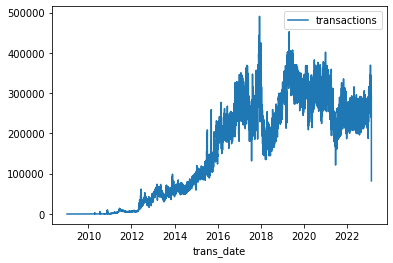

In [34]:
transactions_by_date.set_index('trans_date').plot()

As you can see, common table expressions (CTEs) let you shift a lot of your data cleaning into SQL. **That's an especially good thing in the case of BigQuery, because it is vastly faster than doing the work in Pandas.**

### Joining data

When our data lives across different tables, how do we analyze it? By
JOINing the tables together. A `JOIN` combines rows in the left table with
corresponding rows in the right table, where the meaning of “corresponding” is based on how we specify the join.

GitHub is the most popular place to collaborate on software projects. A GitHub **repository** (or **repo**) is a collection of files associated with a specific project. Most repos on GitHub are shared under a specific legal license, which determines the legal restrictions on how they are used.  **For our example, we're going to look at how many different files have been released under each license.** 

We'll work with two tables in the database.  The first table is the `licenses` table, which provides the name of each GitHub repo (in the `repo_name` column) and its corresponding license.  Here's a view of the first five rows.

In [35]:
# Construct a reference to the "github_repos" dataset
dataset_ref = client.dataset("github_repos", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "licenses" table
licenses_ref = dataset_ref.table("licenses")

# API request - fetch the table
licenses_table = client.get_table(licenses_ref)

# Preview the first five lines of the "licenses" table
client.list_rows(licenses_table, max_results=5).to_dataframe()

,repo_name,license
0,autarch/Dist-Zilla-Plugin-Test-TidyAll,artistic-2.0
1,thundergnat/Prime-Factor,artistic-2.0
2,kusha-b-k/Turabian_Engin_Fan,artistic-2.0
3,onlinepremiumoutlet/onlinepremiumoutlet.github.io,artistic-2.0
4,huangyuanlove/LiaoBa_Service,artistic-2.0


The second table is the `sample_files` table, which provides, among other information, the GitHub repo that each file belongs to (in the `repo_name` column).  The first several rows of this table are printed below.

In [ ]:
# Construct a reference to the "sample_files" table
files_ref = dataset_ref.table("sample_files")

# API request - fetch the table
files_table = client.get_table(files_ref)

# Preview the first five lines of the "sample_files" table
client.list_rows(files_table, max_results=5).to_dataframe()

,repo_name,ref,path,mode,id,symlink_target
0,git/git,refs/heads/master,RelNotes,40960,62615ffa4e97803da96aefbc798ab50f949a8db7,Documentation/RelNotes/2.10.0.txt
1,np/ling,refs/heads/master,tests/success/plug_compose.t/plug_compose.ll,40960,0c1605e4b447158085656487dc477f7670c4bac1,../../../fixtures/all/plug_compose.ll
2,np/ling,refs/heads/master,fixtures/strict-par-success/parallel_assoc_lef...,40960,b59bff84ec03d12fabd3b51a27ed7e39a180097e,../all/parallel_assoc_left.ll
3,np/ling,refs/heads/master,fixtures/sequence/parallel_assoc_2tensor2_left.ll,40960,f29523e3fb65702d99478e429eac6f801f32152b,../all/parallel_assoc_2tensor2_left.ll
4,np/ling,refs/heads/master,fixtures/success/my_dual.ll,40960,38a3af095088f90dfc956cb990e893909c3ab286,../all/my_dual.ll


Next, we write a query that uses information in both tables to determine how many files are released in each license.

In [ ]:
# Query to determine the number of files per license, sorted by number of files
query = """
        SELECT L.license, COUNT(1) AS number_of_files
        FROM `bigquery-public-data.github_repos.sample_files` AS sf
        INNER JOIN `bigquery-public-data.github_repos.licenses` AS L 
            ON sf.repo_name = L.repo_name
        GROUP BY L.license
        ORDER BY number_of_files DESC
        """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
file_count_by_license = query_job.to_dataframe()

It's a big query, and so we'll investigate each piece separately.

![](https://i.imgur.com/QeufD01.png)
    
We'll begin with the **JOIN** (highlighted in blue above).  This specifies the sources of data and how to join them. We use **ON** to specify that we combine the tables by matching the values in the `repo_name` columns in the tables.

Next, we'll talk about **SELECT** and **GROUP BY** (highlighted in yellow).  The **GROUP BY** breaks the data into a different group for each license, before we **COUNT** the number of rows in the `sample_files` table that corresponds to each license.  (Remember that you can count the number of rows with `COUNT(1)`.) 

Finally, the **ORDER BY** (highlighted in purple) sorts the results so that licenses with more files appear first.

It was a big query, but it gave us a nice table summarizing how many files have been committed under each license:  

In [ ]:
# Print the DataFrame
file_count_by_license

,license,number_of_files
0,mit,20408848
1,gpl-2.0,16440828
2,apache-2.0,7114054
3,gpl-3.0,4840103
4,bsd-3-clause,3149733
5,agpl-3.0,1321015
6,lgpl-2.1,775792
7,bsd-2-clause,687381
8,lgpl-3.0,569941
9,mpl-2.0,458331


There are a few more types of JOIN, along with how to use UNIONs to pull information from multiple tables. We'll work with the [Hacker News](https://www.kaggle.com/hacker-news/hacker-news) dataset. We begin by reviewing the first several rows of the `comments` table.

In [ ]:
# Construct a reference to the "hacker_news" dataset
dataset_ref = client.dataset("hacker_news", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "comments" table
table_ref = dataset_ref.table("comments")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe()

,id,by,author,time,time_ts,text,parent,deleted,dead,ranking
0,2701393,5l,5l,1309184881,2011-06-27 14:28:01+00:00,And the glazier who fixed all the broken windo...,2701243,None,None,0
1,5811403,99,99,1370234048,2013-06-03 04:34:08+00:00,Does canada have the equivalent of H1B/Green c...,5804452,None,None,0
2,21623,AF,AF,1178992400,2007-05-12 17:53:20+00:00,"Speaking of Rails, there are other options in ...",21611,None,None,0
3,10159727,EA,EA,1441206574,2015-09-02 15:09:34+00:00,Humans and large livestock (and maybe even pet...,10159396,None,None,0
4,2988424,Iv,Iv,1315853580,2011-09-12 18:53:00+00:00,I must say I reacted in the same way when I re...,2988179,None,None,0


In [ ]:
# Construct a reference to the "stories" table
table_ref = dataset_ref.table("stories")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe()

,id,by,score,time,time_ts,title,url,text,deleted,dead,descendants,author
0,6940813,sarath237,0,1387536270,2013-12-20 10:44:30+00:00,Sheryl Brindo Hot Pics,http://www.youtube.com/watch?v=ym1cyxneB0Y,Sheryl Brindo Hot Pics,None,True,NaN,sarath237
1,6991401,123123321321,0,1388508751,2013-12-31 16:52:31+00:00,Are you people also put off by the culture of ...,,They&#x27;re pretty explicitly &#x27;startup f...,None,True,NaN,123123321321
2,1531556,ssn,0,1279617234,2010-07-20 09:13:54+00:00,New UI for Google Image Search,http://googlesystem.blogspot.com/2010/07/googl...,Again following on Bing's lead.,None,None,0.0,ssn
3,5012398,hoju,0,1357387877,2013-01-05 12:11:17+00:00,Historic website screenshots,http://webscraping.com/blog/Generate-website-s...,Python script to generate historic screenshots...,None,None,0.0,hoju
4,7214182,kogir,0,1401561740,2014-05-31 18:42:20+00:00,Placeholder,,Mind the gap.,None,None,0.0,kogir


The query below pulls information from the `stories` and `comments` tables to create a table showing all stories posted on January 1, 2012, along with the corresponding number of comments.  We use a **LEFT JOIN** so that the results include stories that didn't receive any comments.

In [ ]:
# Query to select all stories posted on January 1, 2012, with number of comments
join_query = """
             WITH c AS
             (
             SELECT parent, COUNT(*) as num_comments
             FROM `bigquery-public-data.hacker_news.comments` 
             GROUP BY parent
             )
             SELECT s.id as story_id, s.by, s.title, c.num_comments
             FROM `bigquery-public-data.hacker_news.stories` AS s
             LEFT JOIN c
             ON s.id = c.parent
             WHERE EXTRACT(DATE FROM s.time_ts) = '2012-01-01'
             ORDER BY c.num_comments DESC
             """

# Run the query, and return a pandas DataFrame
join_result = client.query(join_query).result().to_dataframe()
join_result.head()

,story_id,by,title,num_comments
0,3412900,whoishiring,Ask HN: Who is Hiring? (January 2012),154.0
1,3412901,whoishiring,Ask HN: Freelancer? Seeking freelancer? (Janua...,97.0
2,3412643,jemeshsu,Avoid Apress,30.0
3,3414012,ramanujam,Impress.js - a Prezi like implementation using...,27.0
4,3412891,Brajeshwar,"There's no shame in code that is simply ""good ...",27.0


Since the results are ordered by the `num_comments` column, stories without comments appear at the end of the DataFrame.  (Remember that **NaN** stands for "not a number".)

In [ ]:
# None of these stories received any comments
join_result.tail()

,story_id,by,title,num_comments
439,3412721,kooljp,Carolina Panthers vs New Orleans Saints Live S...,NaN
440,3413606,willvarfar,Poll: what is your (Lipson-Shiu) personality t...,NaN
441,3413159,see_cloudtweaks,IBM Cloud Computing: Overview - United States,NaN
442,3412972,abionic,"Is SPLUNK eating up your disk space, might be ...",NaN
443,3412388,deviceguru,Google TV 2.0 screenshot tour,NaN


As you've seen, JOINs horizontally combine results from different tables. If you instead would like to vertically concatenate columns, you can do so with a `UNION`. 

Next, we write a query to select all usernames corresponding to users who wrote stories or comments on January 1, 2014.  We use **UNION DISTINCT** (instead of **UNION ALL**) to ensure that each user appears in the table at most once.

In [ ]:
# Query to select all users who posted stories or comments on January 1, 2014
union_query = """
              SELECT c.by
              FROM `bigquery-public-data.hacker_news.comments` AS c
              WHERE EXTRACT(DATE FROM c.time_ts) = '2014-01-01'
              UNION DISTINCT
              SELECT s.by
              FROM `bigquery-public-data.hacker_news.stories` AS s
              WHERE EXTRACT(DATE FROM s.time_ts) = '2014-01-01'
              """

# Run the query, and return a pandas DataFrame
union_result = client.query(union_query).result().to_dataframe()
union_result.head()

,by
0,kawsper
1,mayrund
2,webmaven
3,kmfrk
4,rbobby


To get the number of users who posted on January 1, 2014, we need only take the length of the DataFrame.

In [ ]:
# Number of users who posted stories or comments on January 1, 2014
len(union_result)

2282

### Analytic Function

You can also define analytic functions, which also operate on a set of rows like aggregation function. However, unlike aggregate functions, analytic functions return a (potentially different) value for each row in the original table. Analytic functions allow us to perform complex calculations with relatively straightforward syntax. For instance, we can quickly calculate moving averages and running totals, among other quantities.

We'll work with the [San Francisco Open Data](https://www.kaggle.com/datasf/san-francisco) dataset.

In [ ]:
# Construct a reference to the "san_francisco" dataset
dataset_ref = client.dataset("san_francisco", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "bikeshare_trips" table
table_ref = dataset_ref.table("bikeshare_trips")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe()

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type
0,944732,2618,2015-09-24 17:22:00+00:00,Mezes,83,2015-09-24 18:06:00+00:00,Mezes,83,653,94063,Customer
1,984595,5957,2015-10-25 18:12:00+00:00,Mezes,83,2015-10-25 19:51:00+00:00,Mezes,83,52,nil,Customer
2,984596,5913,2015-10-25 18:13:00+00:00,Mezes,83,2015-10-25 19:51:00+00:00,Mezes,83,121,nil,Customer
3,1129385,6079,2016-03-18 10:33:00+00:00,Mezes,83,2016-03-18 12:14:00+00:00,Mezes,83,208,94070,Customer
4,1030383,5780,2015-12-06 10:52:00+00:00,Mezes,83,2015-12-06 12:28:00+00:00,Mezes,83,44,94064,Customer


Each row of the table corresponds to a different bike trip, and we can use an analytic function to **calculate the cumulative number of trips for each date in 2015.**

In [ ]:
# Query to count the (cumulative) number of trips per day
num_trips_query = """
                  WITH trips_by_day AS
                  (
                  SELECT DATE(start_date) AS trip_date,
                      COUNT(*) as num_trips
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE EXTRACT(YEAR FROM start_date) = 2015
                  GROUP BY trip_date
                  )
                  SELECT *,
                      SUM(num_trips) 
                          OVER (
                               ORDER BY trip_date
                               ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
                               ) AS cumulative_trips
                      FROM trips_by_day
                  """

# Run the query, and return a pandas DataFrame
num_trips_result = client.query(num_trips_query).result().to_dataframe()
num_trips_result.head()

,trip_date,num_trips,cumulative_trips
0,2015-01-01,181,181
1,2015-01-02,428,609
2,2015-01-03,283,892
3,2015-01-04,206,1098
4,2015-01-05,1186,2284


The query uses a [common table expression (CTE)](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax#with_clause) to first calculate the daily number of trips.  Then, we use **SUM()** as an aggregate function.
- Since there is no **PARTITION BY** clause, the entire table is treated as a single partition.
- The **ORDER BY** clause orders the rows by date, where earlier dates appear first. 
- By setting the **window frame** clause to `ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW`, we ensure that all rows up to and including the current date are used to calculate the (cumulative) sum. See https://cloud.google.com/bigquery/docs/reference/standard-sql/analytic-function-concepts#def_window_frame for more details.

The next query **tracks the stations where each bike began (in `start_station_id`) and ended (in `end_station_id`) the day on October 25, 2015.**

In [ ]:
# Query to track beginning and ending stations on October 25, 2015, for each bike
start_end_query = """
                  SELECT bike_number,
                      TIME(start_date) AS trip_time,
                      FIRST_VALUE(start_station_id)
                          OVER (
                               PARTITION BY bike_number
                               ORDER BY start_date
                               ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                               ) AS first_station_id,
                      LAST_VALUE(end_station_id)
                          OVER (
                               PARTITION BY bike_number
                               ORDER BY start_date
                               ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                               ) AS last_station_id,
                      start_station_id,
                      end_station_id
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE DATE(start_date) = '2015-10-25' 
                  """

# Run the query, and return a pandas DataFrame
start_end_result = client.query(start_end_query).result().to_dataframe()
start_end_result.head()

,bike_number,trip_time,first_station_id,last_station_id,start_station_id,end_station_id
0,25,11:43:00,77,51,77,60
1,25,12:14:00,77,51,60,51
2,111,14:41:00,69,65,69,65
3,403,16:54:00,51,54,51,54
4,301,13:36:00,35,34,35,35


The query uses both **FIRST_VALUE()** and **LAST_VALUE()** as analytic functions.
- The **PARTITION BY** clause breaks the data into partitions based on the `bike_number` column.  Since this column holds unique identifiers for the bikes, this ensures the calculations are performed separately for each bike.
- The **ORDER BY** clause puts the rows within each partition in chronological order.
- Since the **window frame** clause is `ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING`, for each row, its entire partition is used to perform the calculation.  (_This ensures the calculated values for rows in the same partition are identical._)

You can check https://cloud.google.com/bigquery/docs/reference/standard-sql/introduction and https://googleapis.dev/python/bigquery/latest/index.html for more details.

## Data Wrangling with Pandas

### `Series` objects
The `pandas` library contains these useful data structures:
* `Series` objects, that we will discuss now. A `Series` object is 1D array, similar to a column in a spreadsheet (with a column name and row labels).
* `DataFrame` objects. This is a 2D table, similar to a spreadsheet (with column names and row labels).

#### Creating a `Series`
Let's start by creating our first `Series` object!

In [ ]:
s = pd.Series([2,-1,3,5])
s

0    2
1   -1
2    3
3    5
dtype: int64

Arithmetic operations on `Series` are also possible, and they apply *elementwise*, just like for `ndarray`s:

In [ ]:
s + [1000,2000,3000,4000]

0    1002
1    1999
2    3003
3    4005
dtype: int64

In [ ]:
s + 1000

0    1002
1     999
2    1003
3    1005
dtype: int64

#### Index labels
Each item in a `Series` object has a unique identifier called the *index label*. By default, it is simply the rank of the item in the `Series` (starting at `0`) but you can also set the index labels manually:

In [ ]:
s2 = pd.Series([68, 83, 112, 68], index=["alice", "bob", "charles", "darwin"])
s2

alice       68
bob         83
charles    112
darwin      68
dtype: int64

You can then use the `Series` just like a `dict`:

In [ ]:
s2["bob"]

83

You can still access the items by integer location, like in a regular array:

In [ ]:
s2[1]

83

To make it clear when you are accessing, it is recommended to always use the `loc` attribute when accessing by label, and the `iloc` attribute when accessing by integer location:

In [ ]:
s2.loc["bob"]

83

In [ ]:
s2.iloc[1]

83

Slicing a `Series` also slices the index labels:

In [ ]:
s2.iloc[1:3]

bob         83
charles    112
dtype: int64

#### Init from `dict`
You can create a `Series` object from a `dict`. The keys will be used as index labels:

In [ ]:
weights = {"alice": 68, "bob": 83, "colin": 86, "darwin": 68}
s3 = pd.Series(weights)
s3

alice     68
bob       83
colin     86
darwin    68
dtype: int64

When an operation involves multiple `Series` objects, `pandas` automatically aligns items by matching index labels.

In [ ]:
print(s2.keys())
print(s3.keys())

s2 + s3

Index(['alice', 'bob', 'charles', 'darwin'], dtype='object')
Index(['alice', 'bob', 'colin', 'darwin'], dtype='object')


alice      136.0
bob        166.0
charles      NaN
colin        NaN
darwin     136.0
dtype: float64

The resulting `Series` contains the union of index labels from `s2` and `s3`. Since `"colin"` is missing from `s2` and `"charles"` is missing from `s3`, these items have a `NaN` result value. (ie. Not-a-Number means *missing*).

Automatic alignment is very handy when working with data that may come from various sources with varying structure and missing items

#### Init with a scalar
You can also initialize a `Series` object using a scalar and a list of index labels: all items will be set to the scalar.

In [ ]:
meaning = pd.Series(42, ["life", "universe", "everything"])
meaning

life          42
universe      42
everything    42
dtype: int64

Pandas makes it easy to plot `Series` data using matplotlib (for more details on matplotlib. Just import matplotlib and call the `plot()` method:

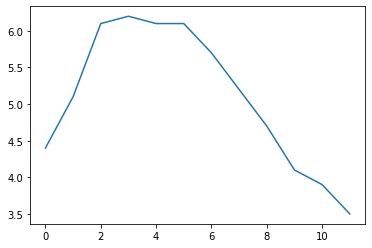

In [ ]:
temperatures = [4.4,5.1,6.1,6.2,6.1,6.1,5.7,5.2,4.7,4.1,3.9,3.5]
s4 = pd.Series(temperatures, name="Temperature")
s4.plot()
plt.show()

You can easily convert it to Numpy array by dicarding the index. 

In [ ]:
s4.to_numpy()

array([4.4, 5.1, 6.1, 6.2, 6.1, 6.1, 5.7, 5.2, 4.7, 4.1, 3.9, 3.5])

There are *many* options for plotting your data. It is not necessary to list them all here: if you need a particular type of plot (histograms, pie charts, etc.), just look for it in the excellent [Visualization](http://pandas.pydata.org/pandas-docs/stable/visualization.html) section of pandas' documentation, and look at the example code.

### Handling time
Many datasets have timestamps, and pandas is awesome at manipulating such data:
* it can represent periods (such as 2016Q3) and frequencies (such as "monthly"),
* it can convert periods to actual timestamps, and *vice versa*,
* it can resample data and aggregate values any way you like,
* it can handle timezones.

#### Time range
Let's start by creating a time series using `pd.date_range()`. This returns a `DatetimeIndex` containing one datetime per hour for 12 hours starting on April 23th 2022 at 5:30pm.

In [ ]:
dates = pd.date_range('2022/04/23 5:30pm', periods=12, freq='H')
dates

DatetimeIndex(['2022-04-23 17:30:00', '2022-04-23 18:30:00',
               '2022-04-23 19:30:00', '2022-04-23 20:30:00',
               '2022-04-23 21:30:00', '2022-04-23 22:30:00',
               '2022-04-23 23:30:00', '2022-04-24 00:30:00',
               '2022-04-24 01:30:00', '2022-04-24 02:30:00',
               '2022-04-24 03:30:00', '2022-04-24 04:30:00'],
              dtype='datetime64[ns]', freq='H')

This `DatetimeIndex` may be used as an index in a `Series`:

In [ ]:
temp_series = pd.Series(temperatures, dates)
temp_series

2022-04-23 17:30:00    4.4
2022-04-23 18:30:00    5.1
2022-04-23 19:30:00    6.1
2022-04-23 20:30:00    6.2
2022-04-23 21:30:00    6.1
2022-04-23 22:30:00    6.1
2022-04-23 23:30:00    5.7
2022-04-24 00:30:00    5.2
2022-04-24 01:30:00    4.7
2022-04-24 02:30:00    4.1
2022-04-24 03:30:00    3.9
2022-04-24 04:30:00    3.5
Freq: H, dtype: float64

Let's plot this series:

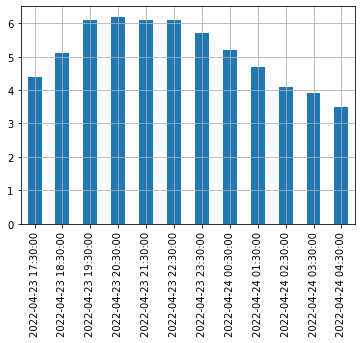

In [ ]:
temp_series.plot(kind="bar")

plt.grid(True)
plt.show()

### Periods
The `pd.period_range()` function returns a `PeriodIndex` instead of a `DatetimeIndex`. For example, let's get all quarters in 2016 and 2017:

In [ ]:
quarters = pd.period_range('2021Q1', periods=8, freq='Q')
quarters

PeriodIndex(['2021Q1', '2021Q2', '2021Q3', '2021Q4', '2022Q1', '2022Q2',
             '2022Q3', '2022Q4'],
            dtype='period[Q-DEC]')

Adding a number `N` to a `PeriodIndex` shifts the periods by `N` times the `PeriodIndex`'s frequency:

In [ ]:
quarters + 3

PeriodIndex(['2021Q4', '2022Q1', '2022Q2', '2022Q3', '2022Q4', '2023Q1',
             '2023Q2', '2023Q3'],
            dtype='period[Q-DEC]')

Pandas also provides many other time-related functions that we recommend you check out in the [documentation](http://pandas.pydata.org/pandas-docs/stable/timeseries.html)

### `DataFrame` objects
A DataFrame object represents a spreadsheet, with cell values, column names and row index labels. You can define expressions to compute columns based on other columns, create pivot-tables, group rows, draw graphs, etc. You can see `DataFrame`s as dictionaries of `Series`.


#### Creating a `DataFrame`
You can create a DataFrame by passing a dictionary of `Series` objects:

In [ ]:
people_dict = {
    "weight": pd.Series([68, 83, 112], index=["alice", "bob", "charles"]),
    "birthyear": pd.Series([1984, 1985, 1992], index=["bob", "alice", "charles"], name="year"),
    "children": pd.Series([0, 3], index=["charles", "bob"]),
    "hobby": pd.Series(["Biking", "Dancing"], index=["alice", "bob"]),
}
people = pd.DataFrame(people_dict)
people

,weight,birthyear,children,hobby
alice,68,1985,NaN,Biking
bob,83,1984,3.0,Dancing
charles,112,1992,0.0,NaN


A few things to note:
* the `Series` were automatically aligned based on their index,
* missing values are represented as `NaN`,
* `Series` names are ignored (the name `"year"` was dropped),
* `DataFrame`s are displayed nicely in Jupyter notebooks!

You can access columns pretty much as you would expect. They are returned as `Series` objects:

In [ ]:
people["birthyear"]

alice      1985
bob        1984
charles    1992
Name: birthyear, dtype: int64

You can also get multiple columns at once:

In [ ]:
people[["birthyear", "hobby"]]

,birthyear,hobby
alice,1985,Biking
bob,1984,Dancing
charles,1992,NaN


Another convenient way to create a `DataFrame` is to pass all the values to the constructor as an `ndarray`, or a list of lists, and specify the column names and row index labels separately:

In [ ]:
values = [
            [1985, np.nan, "Biking",   68],
            [1984, 3,      "Dancing",  83],
            [1992, 0,      np.nan,    112]
         ]
d3 = pd.DataFrame(
        values,
        columns=["birthyear", "children", "hobby", "weight"],
        index=["alice", "bob", "charles"]
     )
d3

,birthyear,children,hobby,weight
alice,1985,NaN,Biking,68
bob,1984,3.0,Dancing,83
charles,1992,0.0,NaN,112


To specify missing values, you can either use `np.nan` or NumPy's masked arrays:

In [ ]:
masked_array = np.ma.asarray(values, dtype=np.object)
masked_array[(0, 2), (1, 2)] = np.ma.masked
d3 = pd.DataFrame(
        masked_array,
        columns=["birthyear", "children", "hobby", "weight"],
        index=["alice", "bob", "charles"]
     )
d3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


,birthyear,children,hobby,weight
alice,1985,NaN,Biking,68
bob,1984,3,Dancing,83
charles,1992,0,NaN,112


You can also create multi-index datafram as follows:

In [ ]:
df = pd.DataFrame(
  {"a" : [4 ,5, 6],
  "b" : [7, 8, 9],
  "c" : [10, 11, 12]},
index = pd.MultiIndex.from_tuples(
  [('d',1),('d',2),('e',2)], names=['n','v'])
)
df

a  b   c
n v          
d 1  4  7  10
  2  5  8  11
e 2  6  9  12

If all columns are tuples of the same size, then they are understood as a multi-index. The same goes for row index labels. For example:

In [ ]:
d5 = pd.DataFrame(
  {
    ("public", "birthyear"):
        {("Paris","alice"):1985, ("Paris","bob"): 1984, ("London","charles"): 1992},
    ("public", "hobby"):
        {("Paris","alice"):"Biking", ("Paris","bob"): "Dancing"},
    ("private", "weight"):
        {("Paris","alice"):68, ("Paris","bob"): 83, ("London","charles"): 112},
    ("private", "children"):
        {("Paris", "alice"):np.nan, ("Paris","bob"): 3, ("London","charles"): 0}
  }
)
d5

public          private         
               birthyear    hobby  weight children
Paris  alice        1985   Biking      68      NaN
       bob          1984  Dancing      83      3.0
London charles      1992      NaN     112      0.0

You can now get a DataFrame containing all the "public" columns very simply:

In [ ]:
d5["public"]

birthyear    hobby
Paris  alice         1985   Biking
       bob           1984  Dancing
London charles       1992      NaN

It is noted that most methods return modified copies in pandas.

#### Subsets - Accessing rows
Let's go back to the `people` `DataFrame`:

In [ ]:
people

,weight,birthyear,children,hobby
alice,68,1985,NaN,Biking
bob,83,1984,3.0,Dancing
charles,112,1992,0.0,NaN


**The `loc` attribute lets you access rows instead of columns.** The result is a `Series` object in which the `DataFrame`'s column names are mapped to row index labels:

In [ ]:
people.loc["charles"]

weight        112
birthyear    1992
children      0.0
hobby         NaN
Name: charles, dtype: object

You can also access rows by integer location using the `iloc` attribute:

In [ ]:
people.iloc[2]

weight        112
birthyear    1992
children      0.0
hobby         NaN
Name: charles, dtype: object

You can also get a slice of rows, and this returns a `DataFrame` object:

In [ ]:
people.iloc[1:3]

,weight,birthyear,children,hobby
bob,83,1984,3.0,Dancing
charles,112,1992,0.0,NaN


Finally, you can pass a boolean array to get the matching rows. This is most useful when combined with boolean expressions:

In [ ]:
people[people["birthyear"] < 1990]

,weight,birthyear,children,hobby
alice,68,1985,NaN,Biking
bob,83,1984,3.0,Dancing


You can also accessing columns by specifiying the second axis:

In [ ]:
people.iloc[:,2]

alice      NaN
bob        3.0
charles    0.0
Name: children, dtype: float64

#### Adding and removing columns
You can generally treat `DataFrame` objects like dictionaries of `Series`, so the following work fine:

In [ ]:
people

,weight,birthyear,children,hobby
alice,68,1985,NaN,Biking
bob,83,1984,3.0,Dancing
charles,112,1992,0.0,NaN


In [ ]:
people["age"] = 2018 - people["birthyear"]  # adds a new column "age"
people["over 30"] = people["age"] > 30      # adds another column "over 30"
birthyears = people.pop("birthyear")
people.drop(columns=['children'], inplace=True) # drop a column inplace
people

,weight,hobby,age,over 30
alice,68,Biking,33,True
bob,83,Dancing,34,True
charles,112,NaN,26,False


In [ ]:
birthyears

alice      1985
bob        1984
charles    1992
Name: birthyear, dtype: int64

When you add a new column, it must have the same number of rows. Missing rows are filled with NaN, and extra rows are ignored:

In [ ]:
people["pets"] = pd.Series({"bob": 0, "charles": 5, "eugene":1})  # alice is missing, eugene is ignored
people

,weight,hobby,age,over 30,pets
alice,68,Biking,33,True,NaN
bob,83,Dancing,34,True,0.0
charles,112,NaN,26,False,5.0


When adding a new column, it is added at the end (on the right) by default. You can also insert a column anywhere else using the `insert()` method:

In [ ]:
people.insert(1, "height", [172, 181, 185])
people

,weight,height,hobby,age,over 30,pets
alice,68,172,Biking,33,True,NaN
bob,83,181,Dancing,34,True,0.0
charles,112,185,NaN,26,False,5.0


You can also create new columns by calling the `assign()` method. Note that this returns a new `DataFrame` object, the original is not modified

In [ ]:
p2 = people.assign(
    bmi = people["weight"] / (people["height"] / 100) ** 2,
    has_pets = people["pets"] > 0
)
p2

,weight,height,hobby,age,over 30,pets,bmi,has_pets
alice,68,172,Biking,33,True,NaN,22.985398,False
bob,83,181,Dancing,34,True,0.0,25.335002,False
charles,112,185,NaN,26,False,5.0,32.724617,True


You can also rename the column name:

In [ ]:
p2.rename(columns={'bmi':'body_mass_index'})

,weight,height,hobby,age,over 30,pets,body_mass_index,has_pets
alice,68,172,Biking,33,True,NaN,22.985398,False
bob,83,181,Dancing,34,True,0.0,25.335002,False
charles,112,185,NaN,26,False,5.0,32.724617,True


#### Evaluating an expression
A great feature supported by pandas is expression evaluation. This relies on the `numexpr` library which must be installed.

In [ ]:
people.eval("weight / (height/100) ** 2 > 25")

alice      False
bob         True
charles     True
dtype: bool

Assignment expressions are also supported. Let's set `inplace=True` to directly modify the `DataFrame` rather than getting a modified copy:

In [ ]:
people.eval("body_mass_index = weight / (height/100) ** 2", inplace=True)
people

,weight,height,hobby,age,over 30,pets,body_mass_index
alice,68,172,Biking,33,True,NaN,22.985398
bob,83,181,Dancing,34,True,0.0,25.335002
charles,112,185,NaN,26,False,5.0,32.724617


You can use a local or global variable in an expression by prefixing it with `'@'`:

In [ ]:
overweight_threshold = 30
people.eval("overweight = body_mass_index > @overweight_threshold", inplace=True)
people

,weight,height,hobby,age,over 30,pets,body_mass_index,overweight
alice,68,172,Biking,33,True,NaN,22.985398,False
bob,83,181,Dancing,34,True,0.0,25.335002,False
charles,112,185,NaN,26,False,5.0,32.724617,True


#### Querying a `DataFrame`
The `query()` method lets you **filter a `DataFrame` based on a query expression**:

In [ ]:
people.query("age > 30 and pets == 0")

,weight,height,hobby,age,over 30,pets,body_mass_index,overweight
bob,83,181,Dancing,34,True,0.0,25.335002,False


#### Sorting a `DataFrame`
You can sort a `DataFrame` by calling its `sort_index` method. By default it sorts the rows by their index label, in ascending order, but let's reverse the order:

In [ ]:
people.sort_index(ascending=False)

,weight,height,hobby,age,over 30,pets,body_mass_index,overweight
charles,112,185,NaN,26,False,5.0,32.724617,True
bob,83,181,Dancing,34,True,0.0,25.335002,False
alice,68,172,Biking,33,True,NaN,22.985398,False


Note that `sort_index` returned a sorted *copy* of the `DataFrame`. To modify `people` directly, we can set the `inplace` argument to `True`. Also, we can sort the columns instead of the rows by setting `axis=1`:

In [ ]:
people.sort_index(axis=1, inplace=True)
people

,age,body_mass_index,height,hobby,over 30,overweight,pets,weight
alice,33,22.985398,172,Biking,True,False,NaN,68
bob,34,25.335002,181,Dancing,True,False,0.0,83
charles,26,32.724617,185,NaN,False,True,5.0,112


To sort the `DataFrame` by the values instead of the labels, we can use `sort_values` and specify the column to sort by:

In [ ]:
people.sort_values(by="age", inplace=True)
people

,age,body_mass_index,height,hobby,over 30,overweight,pets,weight
charles,26,32.724617,185,NaN,False,True,5.0,112
alice,33,22.985398,172,Biking,True,False,NaN,68
bob,34,25.335002,181,Dancing,True,False,0.0,83


#### Plotting a `DataFrame`
Just like for `Series`, pandas makes it easy to draw nice graphs based on a `DataFrame`.

For example, it is trivial to create a line plot from a `DataFrame`'s data by calling its `plot` method:

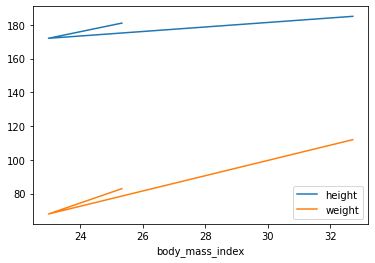

In [ ]:
people.plot(kind = "line", x = "body_mass_index", y = ["height", "weight"])
plt.show()

Again, there are way too many options to list here: the best option is to scroll through the [Visualization](http://pandas.pydata.org/pandas-docs/stable/visualization.html) page in pandas' documentation, find the plot you are interested in and look at the example code.

#### Operations on `DataFrame`s
Although `DataFrame`s do not try to mimick NumPy arrays, there are a few similarities. Let's create a `DataFrame` to demonstrate this:

In [ ]:
grades_array = np.array([[8,8,9],[10,9,9],[4, 8, 2], [9, 10, 10]])
grades = pd.DataFrame(grades_array, columns=["sep", "oct", "nov"], index=["alice","bob","charles","darwin"])
grades

,sep,oct,nov
alice,8,8,9
bob,10,9,9
charles,4,8,2
darwin,9,10,10


You can apply NumPy mathematical functions on a `DataFrame`: the function is applied to all values:

In [ ]:
np.sqrt(grades)

,sep,oct,nov
alice,2.828427,2.828427,3.000000
bob,3.162278,3.000000,3.000000
charles,2.000000,2.828427,1.414214
darwin,3.000000,3.162278,3.162278


In [ ]:
grades + 1

,sep,oct,nov
alice,9,9,10
bob,11,10,10
charles,5,9,3
darwin,10,11,11


Aggregation operations, such as computing the `max`, the `sum` or the `mean` of a `DataFrame`, apply to each column, and you get back a `Series` object:

In [ ]:
grades.mean()

sep    7.75
oct    8.75
nov    7.50
dtype: float64

Most of these functions take an optional `axis` parameter which lets you specify along which axis of the `DataFrame` you want the operation executed. The default is `axis=0`, meaning that the operation is executed vertically (on each column). You can set `axis=1` to execute the operation horizontally (on each row). For example, let's find out which students had all grades greater than `5`:

In [ ]:
(grades > 5).all(axis = 1)

alice       True
bob         True
charles    False
darwin      True
dtype: bool

If you add a `Series` object to a `DataFrame` (or execute any other binary operation), pandas attempts to broadcast the operation to all *rows* in the `DataFrame`. This only works if the `Series` has the same size as the `DataFrame`s rows. For example, let's subtract the `mean` of the `DataFrame` (a `Series` object) from the `DataFrame`:

In [ ]:
grades - grades.mean()  # equivalent to: grades - [7.75, 8.75, 7.50]

,sep,oct,nov
alice,0.25,-0.75,1.5
bob,2.25,0.25,1.5
charles,-3.75,-0.75,-5.5
darwin,1.25,1.25,2.5


In [ ]:
# We subtracted `7.75` from all September grades, `8.75` from October grades and `7.50` 
# from November grades. It is equivalent to subtracting this `DataFrame`:
pd.DataFrame([[7.75, 8.75, 7.50]]*4, index=grades.index, columns=grades.columns)

,sep,oct,nov
alice,7.75,8.75,7.5
bob,7.75,8.75,7.5
charles,7.75,8.75,7.5
darwin,7.75,8.75,7.5


If you want to subtract the global mean from every grade, here is one way to do it:

In [ ]:
grades - grades.values.mean() # subtracts the global mean (8.00) from all grades

,sep,oct,nov
alice,0.0,0.0,1.0
bob,2.0,1.0,1.0
charles,-4.0,0.0,-6.0
darwin,1.0,2.0,2.0


In [ ]:
bonus_array = np.array([[0,np.nan,2],[np.nan,1,0],[0, 1, 0], [3, 3, 0]])
bonus_points = pd.DataFrame(bonus_array, columns=["oct", "nov", "dec"], index=["bob","colin", "darwin", "charles"])
bonus_points

,oct,nov,dec
bob,0.0,NaN,2.0
colin,NaN,1.0,0.0
darwin,0.0,1.0,0.0
charles,3.0,3.0,0.0


In [ ]:
grades + bonus_points

,dec,nov,oct,sep
alice,NaN,NaN,NaN,NaN
bob,NaN,NaN,9.0,NaN
charles,NaN,5.0,11.0,NaN
colin,NaN,NaN,NaN,NaN
darwin,NaN,11.0,10.0,NaN


#### Handling missing data
Dealing with missing data is a frequent task when working with real life data. Pandas offers a few tools to handle missing data.
 
Let's try to fix the problem above. For example, we can decide that missing data should result in a zero, instead of `NaN`. We can replace all `NaN` values by a any value using the `fillna()` method:

In [ ]:
(grades + bonus_points).fillna(0)

,dec,nov,oct,sep
alice,0.0,0.0,0.0,0.0
bob,0.0,0.0,9.0,0.0
charles,0.0,5.0,11.0,0.0
colin,0.0,0.0,0.0,0.0
darwin,0.0,11.0,10.0,0.0


In [ ]:
final_grades = grades + bonus_points
final_grades

,dec,nov,oct,sep
alice,NaN,NaN,NaN,NaN
bob,NaN,NaN,9.0,NaN
charles,NaN,5.0,11.0,NaN
colin,NaN,NaN,NaN,NaN
darwin,NaN,11.0,10.0,NaN


We can call the `dropna()` method to get rid of rows that are full of `NaN`s:

In [ ]:
final_grades_clean = final_grades.dropna(how="all")
final_grades_clean

,dec,nov,oct,sep
bob,NaN,NaN,9.0,NaN
charles,NaN,5.0,11.0,NaN
darwin,NaN,11.0,10.0,NaN


Now let's remove columns that are full of `NaN`s by setting the `axis` argument to `1`:

In [ ]:
final_grades_clean = final_grades_clean.dropna(axis=1, how="all")
final_grades_clean

,nov,oct
bob,NaN,9.0
charles,5.0,11.0
darwin,11.0,10.0


#### Aggregating with `groupby`
Similar to the SQL language, pandas allows grouping your data into groups to run calculations over each group.

First, let's add some extra data about each person so we can group them, and let's go back to the `final_grades` `DataFrame` so we can see how `NaN` values are handled:

In [ ]:
final_grades["hobby"] = ["Biking", "Dancing", np.nan, "Dancing", "Biking"]
final_grades

,dec,nov,oct,sep,hobby
alice,NaN,NaN,NaN,NaN,Biking
bob,NaN,NaN,9.0,NaN,Dancing
charles,NaN,5.0,11.0,NaN,NaN
colin,NaN,NaN,NaN,NaN,Dancing
darwin,NaN,11.0,10.0,NaN,Biking


Now let's group data in this `DataFrame` by hobby:

In [ ]:
grouped_grades = final_grades.groupby("hobby")
grouped_grades

We are ready to compute the average grade per hobby:

In [ ]:
grouped_grades.mean()

,dec,nov,oct,sep
hobby,,,,
Biking,NaN,11.0,10.0,NaN
Dancing,NaN,NaN,9.0,NaN


That was easy! Note that the `NaN` values have simply been skipped when computing the means.

#### Pivot tables
Pandas supports spreadsheet-like [pivot tables](https://en.wikipedia.org/wiki/Pivot_table) that allow quick data summarization.

#### Overview functions
When dealing with large `DataFrames`, it is useful to get a quick overview of its content. Pandas offers a few functions for this. First, let's create a large `DataFrame` with a mix of numeric values, missing values and text values. Notice how Jupyter displays only the corners of the `DataFrame`:

In [ ]:
much_data = np.fromfunction(lambda x,y: (x+y*y)%17*11, (10000, 26))
large_df = pd.DataFrame(much_data, columns=list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"))
large_df[large_df % 16 == 0] = np.nan
large_df.insert(3,"some_text", "Blabla")
large_df

,A,B,C,some_text,D,E,F,G,H,I,...,Q,R,S,T,U,V,W,X,Y,Z
0,NaN,11.0,44.0,Blabla,99.0,NaN,88.0,22.0,165.0,143.0,...,11.0,NaN,11.0,44.0,99.0,NaN,88.0,22.0,165.0,143.0
1,11.0,22.0,55.0,Blabla,110.0,NaN,99.0,33.0,NaN,154.0,...,22.0,11.0,22.0,55.0,110.0,NaN,99.0,33.0,NaN,154.0
2,22.0,33.0,66.0,Blabla,121.0,11.0,110.0,44.0,NaN,165.0,...,33.0,22.0,33.0,66.0,121.0,11.0,110.0,44.0,NaN,165.0
3,33.0,44.0,77.0,Blabla,132.0,22.0,121.0,55.0,11.0,NaN,...,44.0,33.0,44.0,77.0,132.0,22.0,121.0,55.0,11.0,NaN
4,44.0,55.0,88.0,Blabla,143.0,33.0,132.0,66.0,22.0,NaN,...,55.0,44.0,55.0,88.0,143.0,33.0,132.0,66.0,22.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,NaN,NaN,33.0,Blabla,88.0,165.0,77.0,11.0,154.0,132.0,...,NaN,NaN,NaN,33.0,88.0,165.0,77.0,11.0,154.0,132.0
9996,NaN,11.0,44.0,Blabla,99.0,NaN,88.0,22.0,165.0,143.0,...,11.0,NaN,11.0,44.0,99.0,NaN,88.0,22.0,165.0,143.0
9997,11.0,22.0,55.0,Blabla,110.0,NaN,99.0,33.0,NaN,154.0,...,22.0,11.0,22.0,55.0,110.0,NaN,99.0,33.0,NaN,154.0
9998,22.0,33.0,66.0,Blabla,121.0,11.0,110.0,44.0,NaN,165.0,...,33.0,22.0,33.0,66.0,121.0,11.0,110.0,44.0,NaN,165.0


The `head()` method returns the top 5 rows:

In [ ]:
large_df.head()

,A,B,C,some_text,D,E,F,G,H,I,...,Q,R,S,T,U,V,W,X,Y,Z
0,NaN,11.0,44.0,Blabla,99.0,NaN,88.0,22.0,165.0,143.0,...,11.0,NaN,11.0,44.0,99.0,NaN,88.0,22.0,165.0,143.0
1,11.0,22.0,55.0,Blabla,110.0,NaN,99.0,33.0,NaN,154.0,...,22.0,11.0,22.0,55.0,110.0,NaN,99.0,33.0,NaN,154.0
2,22.0,33.0,66.0,Blabla,121.0,11.0,110.0,44.0,NaN,165.0,...,33.0,22.0,33.0,66.0,121.0,11.0,110.0,44.0,NaN,165.0
3,33.0,44.0,77.0,Blabla,132.0,22.0,121.0,55.0,11.0,NaN,...,44.0,33.0,44.0,77.0,132.0,22.0,121.0,55.0,11.0,NaN
4,44.0,55.0,88.0,Blabla,143.0,33.0,132.0,66.0,22.0,NaN,...,55.0,44.0,55.0,88.0,143.0,33.0,132.0,66.0,22.0,NaN


Of course there's also a `tail()` function to view the bottom 5 rows. You can pass the number of rows you want:

In [ ]:
large_df.tail(n=2)

,A,B,C,some_text,D,E,F,G,H,I,...,Q,R,S,T,U,V,W,X,Y,Z
9998,22.0,33.0,66.0,Blabla,121.0,11.0,110.0,44.0,NaN,165.0,...,33.0,22.0,33.0,66.0,121.0,11.0,110.0,44.0,NaN,165.0
9999,33.0,44.0,77.0,Blabla,132.0,22.0,121.0,55.0,11.0,NaN,...,44.0,33.0,44.0,77.0,132.0,22.0,121.0,55.0,11.0,NaN


The `info()` method prints out a summary of each columns contents:

In [ ]:
large_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   A          8823 non-null   float64
 1   B          8824 non-null   float64
 2   C          8824 non-null   float64
 3   some_text  10000 non-null  object 
 4   D          8824 non-null   float64
 5   E          8822 non-null   float64
 6   F          8824 non-null   float64
 7   G          8824 non-null   float64
 8   H          8822 non-null   float64
 9   I          8823 non-null   float64
 10  J          8823 non-null   float64
 11  K          8822 non-null   float64
 12  L          8824 non-null   float64
 13  M          8824 non-null   float64
 14  N          8822 non-null   float64
 15  O          8824 non-null   float64
 16  P          8824 non-null   float64
 17  Q          8824 non-null   float64
 18  R          8823 non-null   float64
 19  S          8824 non-null   float64
 20  T      

Finally, the `describe()` method gives a nice overview of the main aggregated values over each column:
* `count`: number of non-null (not NaN) values
* `mean`: mean of non-null values
* `std`: [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation) of non-null values
* `min`: minimum of non-null values
* `25%`, `50%`, `75%`: 25th, 50th and 75th [percentile](https://en.wikipedia.org/wiki/Percentile) of non-null values
* `max`: maximum of non-null values

In [ ]:
large_df.describe()

,A,B,C,D,E,F,G,H,I,J,...,Q,R,S,T,U,V,W,X,Y,Z
count,8823.000000,8824.000000,8824.000000,8824.000000,8822.000000,8824.000000,8824.000000,8822.000000,8823.000000,8823.000000,...,8824.000000,8823.000000,8824.000000,8824.000000,8824.000000,8822.000000,8824.000000,8824.000000,8822.000000,8823.000000
mean,87.977559,87.972575,87.987534,88.012466,87.983791,88.007480,87.977561,88.000000,88.022441,88.022441,...,87.972575,87.977559,87.972575,87.987534,88.012466,87.983791,88.007480,87.977561,88.000000,88.022441
std,47.535911,47.535523,47.521679,47.521679,47.535001,47.519371,47.529755,47.536879,47.535911,47.535911,...,47.535523,47.535911,47.535523,47.521679,47.521679,47.535001,47.519371,47.529755,47.536879,47.535911
min,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,...,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
25%,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,...,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
50%,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,...,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
75%,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,...,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000
max,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,...,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000


#### Saving & loading
Pandas can save `DataFrame`s to various backends, including file formats such as CSV, Excel, JSON, HTML and HDF5, or to a SQL database. Let's create a `DataFrame` to demonstrate this:

In [ ]:
my_df = pd.DataFrame(
    [["Biking", 68.5, 1985, np.nan], ["Dancing", 83.1, 1984, 3]], 
    columns=["hobby","weight","birthyear","children"],
    index=["alice", "bob"]
)
my_df

,hobby,weight,birthyear,children
alice,Biking,68.5,1985,NaN
bob,Dancing,83.1,1984,3.0


#### Saving
Let's save it to CSV, HTML and JSON:

In [ ]:
my_df.to_csv("my_df.csv")
my_df.to_html("my_df.html")
my_df.to_json("my_df.json")

Done! Let's take a peek at what was saved:

In [ ]:
for filename in ("my_df.csv", "my_df.html", "my_df.json"):
    print("#", filename)
    with open(filename, "rt") as f:
        print(f.read())
        print()


# my_df.csv
,hobby,weight,birthyear,children
alice,Biking,68.5,1985,
bob,Dancing,83.1,1984,3.0


# my_df.html
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>hobby</th>
      <th>weight</th>
      <th>birthyear</th>
      <th>children</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>alice</th>
      <td>Biking</td>
      <td>68.5</td>
      <td>1985</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>bob</th>
      <td>Dancing</td>
      <td>83.1</td>
      <td>1984</td>
      <td>3.0</td>
    </tr>
  </tbody>
</table>

# my_df.json
{"hobby":{"alice":"Biking","bob":"Dancing"},"weight":{"alice":68.5,"bob":83.1},"birthyear":{"alice":1985,"bob":1984},"children":{"alice":null,"bob":3.0}}



Note that the index is saved as the first column (with no name) in a CSV file, as `<th>` tags in HTML and as keys in JSON.

Saving to other formats works very similarly, but some formats require extra libraries to be installed. For example, saving to Excel requires the openpyxl library:

In [ ]:
try:
    my_df.to_excel("my_df.xlsx", sheet_name='People')
except ImportError as e:
    print(e)

#### Loading
Now let's load our CSV file back into a `DataFrame`:

In [ ]:
my_df_loaded = pd.read_csv("my_df.csv", index_col=0)
my_df_loaded

,hobby,weight,birthyear,children
alice,Biking,68.5,1985,NaN
bob,Dancing,83.1,1984,3.0


As you might guess, there are similar `read_json`, `read_html`, `read_excel` functions as well.  We can also read data straight from the Internet. For example, let's load the top 1,000 U.S. cities from github:

In [ ]:
us_cities = None
try:
    csv_url = "https://raw.githubusercontent.com/plotly/datasets/master/us-cities-top-1k.csv"
    us_cities = pd.read_csv(csv_url, index_col=0)
    us_cities = us_cities.head()
except IOError as e:
    print(e)
us_cities

,State,Population,lat,lon
City,,,,
Marysville,Washington,63269,48.051764,-122.177082
Perris,California,72326,33.782519,-117.228648
Cleveland,Ohio,390113,41.499320,-81.694361
Worcester,Massachusetts,182544,42.262593,-71.802293
Columbia,South Carolina,133358,34.000710,-81.034814


There are more options available, in particular regarding datetime format. Check out the [documentation](http://pandas.pydata.org/pandas-docs/stable/io.html) for more details.

#### Combining `DataFrame`s

One powerful feature of pandas is it's ability to perform SQL-like joins on `DataFrame`s. Various types of joins are supported: inner joins, left/right outer joins and full joins. To illustrate this, let's start by creating a couple simple `DataFrame`s:

In [ ]:
city_loc = pd.DataFrame(
    [
        ["CA", "San Francisco", 37.781334, -122.416728],
        ["NY", "New York", 40.705649, -74.008344],
        ["FL", "Miami", 25.791100, -80.320733],
        ["OH", "Cleveland", 41.473508, -81.739791],
        ["UT", "Salt Lake City", 40.755851, -111.896657]
    ], columns=["state", "city", "lat", "lng"])
city_loc

,state,city,lat,lng
0,CA,San Francisco,37.781334,-122.416728
1,NY,New York,40.705649,-74.008344
2,FL,Miami,25.791100,-80.320733
3,OH,Cleveland,41.473508,-81.739791
4,UT,Salt Lake City,40.755851,-111.896657


In [ ]:
city_pop = pd.DataFrame(
    [
        [808976, "San Francisco", "California"],
        [8363710, "New York", "New-York"],
        [413201, "Miami", "Florida"],
        [2242193, "Houston", "Texas"]
    ], index=[3,4,5,6], columns=["population", "city", "state"])
city_pop

,population,city,state
3,808976,San Francisco,California
4,8363710,New York,New-York
5,413201,Miami,Florida
6,2242193,Houston,Texas


Now let's join these `DataFrame`s using the `merge()` function:

In [ ]:
pd.merge(left=city_loc, right=city_pop, on="city")

,state_x,city,lat,lng,population,state_y
0,CA,San Francisco,37.781334,-122.416728,808976,California
1,NY,New York,40.705649,-74.008344,8363710,New-York
2,FL,Miami,25.791100,-80.320733,413201,Florida


Note that both `DataFrame`s have a column named `state`, so in the result they got renamed to `state_x` and `state_y`.

Also, note that Cleveland, Salt Lake City and Houston were dropped because they don't exist in *both* `DataFrame`s. This is the equivalent of a SQL `INNER JOIN`. If you want a `FULL OUTER JOIN`, where no city gets dropped and `NaN` values are added, you must specify `how="outer"`:

In [ ]:
all_cities = pd.merge(left=city_loc, right=city_pop, on="city", how="outer")
all_cities

,state_x,city,lat,lng,population,state_y
0,CA,San Francisco,37.781334,-122.416728,808976.0,California
1,NY,New York,40.705649,-74.008344,8363710.0,New-York
2,FL,Miami,25.791100,-80.320733,413201.0,Florida
3,OH,Cleveland,41.473508,-81.739791,NaN,NaN
4,UT,Salt Lake City,40.755851,-111.896657,NaN,NaN
5,NaN,Houston,NaN,NaN,2242193.0,Texas


Of course `LEFT OUTER JOIN` is also available by setting `how="left"`: only the cities present in the left `DataFrame` end up in the result. Similarly, with `how="right"` only cities in the right `DataFrame` appear in the result. For example:

In [ ]:
pd.merge(left=city_loc, right=city_pop, on="city", how="right")

,state_x,city,lat,lng,population,state_y
0,CA,San Francisco,37.781334,-122.416728,808976,California
1,NY,New York,40.705649,-74.008344,8363710,New-York
2,FL,Miami,25.791100,-80.320733,413201,Florida
3,NaN,Houston,NaN,NaN,2242193,Texas


If the key to join on is actually in one (or both) `DataFrame`'s index, you must use `left_index=True` and/or `right_index=True`. If the key column names differ, you must use `left_on` and `right_on`. For example:

In [ ]:
city_pop2 = city_pop.copy()
city_pop2.columns = ["population", "name", "state"]
pd.merge(left=city_loc, right=city_pop2, left_on="city", right_on="name")

,state_x,city,lat,lng,population,name,state_y
0,CA,San Francisco,37.781334,-122.416728,808976,San Francisco,California
1,NY,New York,40.705649,-74.008344,8363710,New York,New-York
2,FL,Miami,25.791100,-80.320733,413201,Miami,Florida


#### Concatenation
Rather than joining `DataFrame`s, we may just want to concatenate them. That's what `concat()` is for:

In [ ]:
result_concat = pd.concat([city_loc, city_pop])
result_concat

,state,city,lat,lng,population
0,CA,San Francisco,37.781334,-122.416728,NaN
1,NY,New York,40.705649,-74.008344,NaN
2,FL,Miami,25.791100,-80.320733,NaN
3,OH,Cleveland,41.473508,-81.739791,NaN
4,UT,Salt Lake City,40.755851,-111.896657,NaN
3,California,San Francisco,NaN,NaN,808976.0
4,New-York,New York,NaN,NaN,8363710.0
5,Florida,Miami,NaN,NaN,413201.0
6,Texas,Houston,NaN,NaN,2242193.0


Note that this operation aligned the data horizontally (by columns) but not vertically (by rows). In this example, we end up with multiple rows having the same index (eg. 3). Pandas handles this rather gracefully:

In [ ]:
result_concat.loc[3]

,state,city,lat,lng,population
3,OH,Cleveland,41.473508,-81.739791,NaN
3,California,San Francisco,NaN,NaN,808976.0


Or you can tell pandas to just ignore the index:

In [ ]:
pd.concat([city_loc, city_pop], ignore_index=True)

,state,city,lat,lng,population
0,CA,San Francisco,37.781334,-122.416728,NaN
1,NY,New York,40.705649,-74.008344,NaN
2,FL,Miami,25.791100,-80.320733,NaN
3,OH,Cleveland,41.473508,-81.739791,NaN
4,UT,Salt Lake City,40.755851,-111.896657,NaN
5,California,San Francisco,NaN,NaN,808976.0
6,New-York,New York,NaN,NaN,8363710.0
7,Florida,Miami,NaN,NaN,413201.0
8,Texas,Houston,NaN,NaN,2242193.0


Notice that when a column does not exist in a `DataFrame`, it acts as if it was filled with `NaN` values. If we set `join="inner"`, then only columns that exist in *both* `DataFrame`s are returned:

In [ ]:
pd.concat([city_loc, city_pop], join="inner")

,state,city
0,CA,San Francisco
1,NY,New York
2,FL,Miami
3,OH,Cleveland
4,UT,Salt Lake City
3,California,San Francisco
4,New-York,New York
5,Florida,Miami
6,Texas,Houston


#### Categories
It is quite frequent to have values that represent categories, for example `1` for female and `2` for male, or `"A"` for Good, `"B"` for Average, `"C"` for Bad. These categorical values can be hard to read and cumbersome to handle, but fortunately pandas makes it easy. To illustrate this, let's take the `city_pop` `DataFrame` we created earlier, and add a column that represents a category:

In [ ]:
city_eco = city_pop.copy()
city_eco["eco_code"] = [17, 17, 34, 20]
city_eco

,population,city,state,eco_code
3,808976,San Francisco,California,17
4,8363710,New York,New-York,17
5,413201,Miami,Florida,34
6,2242193,Houston,Texas,20


Right now the `eco_code` column is full of apparently meaningless codes. Let's fix that. First, we will create a new categorical column based on the `eco_code`s:

In [ ]:
city_eco["economy"] = city_eco["eco_code"].astype('category')
city_eco["economy"].cat.categories

Int64Index([17, 20, 34], dtype='int64')

Now we can give each category a meaningful name:

In [ ]:
city_eco["economy"].cat.categories = ["Finance", "Energy", "Tourism"]
city_eco

,population,city,state,eco_code,economy
3,808976,San Francisco,California,17,Finance
4,8363710,New York,New-York,17,Finance
5,413201,Miami,Florida,34,Tourism
6,2242193,Houston,Texas,20,Energy


Note that categorical values are sorted according to their categorical order, *not* their alphabetical order:

In [ ]:
city_eco.sort_values(by="economy", ascending=False)

,population,city,state,eco_code,economy
5,413201,Miami,Florida,34,Tourism
6,2242193,Houston,Texas,20,Energy
3,808976,San Francisco,California,17,Finance
4,8363710,New York,New-York,17,Finance


## What next?
As you probably noticed by now, pandas is quite a large library with *many* features. Although we went through the most important features, there is still a lot to discover. Probably the best way to learn more is to get your hands dirty with some real-life data. It is also a good idea to go through pandas' excellent [documentation](http://pandas.pydata.org/pandas-docs/stable/index.html), in particular the [Cookbook](http://pandas.pydata.org/pandas-docs/stable/cookbook.html).

You can also work with Bigquery in Pandas. Check out https://pandas.pydata.org/docs/reference/api/pandas.read_gbq.html and https://pandas-gbq.readthedocs.io/en/latest/ for more details.

## References

1. https://www.kaggle.com/learn/
2. https://github.com/ageron/handson-ml3
3. https://github.com/wesm/pydata-book.